# Sequence To Sequence With Neural Networks

The encoder-decoder model is a type of neural network that is mainly used for tasks where both the input and output are sequences. This architecture is used when the input and output sequences are not the same length for example translating a sentence from one language to another, summarizing a paragraph, describing an image with a caption or convert speech into text. It works in two stages:

  1) Encoder: The encoder takes the input data like a sentence and processes each word one by one then creates a single, fixed-size summary of the entire input called a context vector or latent space.
  
  2) Decoder: The decoder takes the context vector and begins to produce the output one step at a time.

# Encoder-Decoder Model Architecture

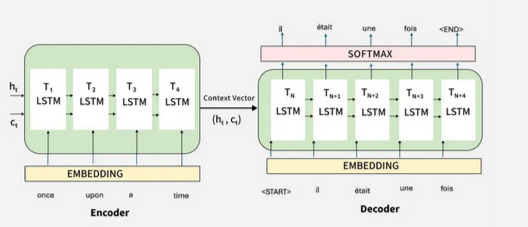

For our above architecture we don't need to provide outputs at encoder side for T1(timestamp) --to T3. At T4 context vector will be created (in short context vector is created at the end of the string (EOS)) and that we need to pass to decoder. Inputs that we are passing we need to pass it in form of vector.

These networks can be different types such as Recurrent Neural Networks (RNNs), Long Short-Term Memory networks (LSTMs), Gated Recurrent Units (GRUs), Convolutional Neural Networks (CNNs) or even more advanced models like Transformers.

The BLEU score (Bilingual Evaluation Understudy) is a metric used in natural language processing (NLP) to evaluate the quality of machine-generated text, particularly in machine translation. The score ranges from 0 to 1, with higher values indicating better translation quality. 

# Disadvantages

Accuracy got reduced when you have large sentences.

**Note:-** Generally we prefer LSTM NN for encoder-decoder

# Machine Learning Language Translation

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np

2025-08-14 23:25:53.179824: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-14 23:25:54.920177: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-14 23:25:55.892520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755194156.671956    4560 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755194156.844786    4560 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755194158.336117    4560 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
batch_size = 64 #batch size for training
epochs = 100 # no. of epochs to train for (in short iteration)
latent_dim = 256 #latent dimensionality of the encoding space
num_samples = 10000 # no. of samples to train on

In [3]:
data_path = '/home/kashika/dummy_projects/NLP/fra-eng/fra.txt'

In [4]:
#Vectorize the data
input_texts=[] #english texts in our case
target_texts = [] #french
input_characters = set() #read unique characters
target_characters = set()

In [5]:
with open(data_path,'r', encoding = 'utf-8') as f:
    lines = f.read().split('\n')
for line in lines[:min(num_samples,len(lines)-1)]:
    input_text, target_text, _ = line.split('\t')
    #we use tab as the start sequence character
    # for the targets, and "\n" as "end sequence" character
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)            

In [6]:
input_texts

['Go.',
 'Go.',
 'Go.',
 'Go.',
 'Hi.',
 'Hi.',
 'Run!',
 'Run!',
 'Run!',
 'Run!',
 'Run!',
 'Run!',
 'Run!',
 'Run!',
 'Run.',
 'Run.',
 'Run.',
 'Run.',
 'Run.',
 'Run.',
 'Run.',
 'Run.',
 'Who?',
 'Wow!',
 'Wow!',
 'Wow!',
 'Duck!',
 'Duck!',
 'Duck!',
 'Fire!',
 'Help!',
 'Hide.',
 'Hide.',
 'Jump!',
 'Jump.',
 'Stop!',
 'Stop!',
 'Stop!',
 'Wait!',
 'Wait!',
 'Wait!',
 'Wait.',
 'Wait.',
 'Wait.',
 'Wait.',
 'Begin.',
 'Begin.',
 'Go on.',
 'Go on.',
 'Go on.',
 'Hello!',
 'Hello!',
 'Hello.',
 'Hello.',
 'Hello.',
 'Hello.',
 'I see.',
 'I see.',
 'I try.',
 'I won!',
 'I won!',
 'I won.',
 'Oh no!',
 'Relax.',
 'Relax.',
 'Relax.',
 'Relax.',
 'Relax.',
 'Relax.',
 'Relax.',
 'Relax.',
 'Relax.',
 'Relax.',
 'Relax.',
 'Relax.',
 'Shoot!',
 'Shoot!',
 'Smile.',
 'Smile.',
 'Smile.',
 'Sorry?',
 'Attack!',
 'Attack!',
 'Attack!',
 'Attack!',
 'Buy it.',
 'Buy it.',
 'Buy it.',
 'Buy it.',
 'Cheers!',
 'Cheers!',
 'Cheers!',
 'Cheers!',
 'Eat it.',
 'Eat it.',
 'Exhale.',
 'Get 

In [7]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [8]:
print('Number of samples:',len(input_texts))
print('Number of unique input tokens:',num_encoder_tokens)
print('Number of unique output tokens:',num_decoder_tokens)
print('Max sequence length for inputs:',max_encoder_seq_length)
print('Max sequence length for outputs:',max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 91
Max sequence length for inputs: 14
Max sequence length for outputs: 59


In [9]:
input_token_index = dict(
[(char,i) for i,char in enumerate(input_characters)])

target_token_index = dict(
[(char,i) for i,char in enumerate(target_characters)])

In [10]:
input_token_index, target_token_index 

({' ': 0,
  '!': 1,
  '"': 2,
  '$': 3,
  '%': 4,
  '&': 5,
  "'": 6,
  ',': 7,
  '-': 8,
  '.': 9,
  '0': 10,
  '1': 11,
  '2': 12,
  '3': 13,
  '5': 14,
  '7': 15,
  '8': 16,
  '9': 17,
  ':': 18,
  '?': 19,
  'A': 20,
  'B': 21,
  'C': 22,
  'D': 23,
  'E': 24,
  'F': 25,
  'G': 26,
  'H': 27,
  'I': 28,
  'J': 29,
  'K': 30,
  'L': 31,
  'M': 32,
  'N': 33,
  'O': 34,
  'P': 35,
  'Q': 36,
  'R': 37,
  'S': 38,
  'T': 39,
  'U': 40,
  'V': 41,
  'W': 42,
  'Y': 43,
  'a': 44,
  'b': 45,
  'c': 46,
  'd': 47,
  'e': 48,
  'f': 49,
  'g': 50,
  'h': 51,
  'i': 52,
  'j': 53,
  'k': 54,
  'l': 55,
  'm': 56,
  'n': 57,
  'o': 58,
  'p': 59,
  'q': 60,
  'r': 61,
  's': 62,
  't': 63,
  'u': 64,
  'v': 65,
  'w': 66,
  'x': 67,
  'y': 68,
  'z': 69},
 {'\t': 0,
  '\n': 1,
  ' ': 2,
  '!': 3,
  '%': 4,
  '&': 5,
  "'": 6,
  ',': 7,
  '-': 8,
  '.': 9,
  '0': 10,
  '1': 11,
  '2': 12,
  '3': 13,
  '5': 14,
  '8': 15,
  '9': 16,
  ':': 17,
  '?': 18,
  'A': 19,
  'B': 20,
  'C': 21,
  'D'

# One Hot Encoding using Numpy

In [11]:
encoder_input_data = np.zeros(
 (len(input_texts),max_encoder_seq_length,num_encoder_tokens),
  dtype='float32')

decoder_input_data = np.zeros(
 (len(input_texts),max_decoder_seq_length,num_decoder_tokens),
  dtype='float32')

decoder_target_data = np.zeros(
 (len(input_texts),max_decoder_seq_length,num_decoder_tokens),
  dtype='float32')

In [12]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[i,t,input_token_index[char]]=1.
    encoder_input_data[i,t+1:,input_token_index[' ']]=1.
    
    for t,char in enumerate(target_text):
        #decoder_target_data is ahead of decoder_input_data by one timestamp
        decoder_input_data[i,t,target_token_index[char]]=1.
        if t>0:
            #decoder_target_data will be ahead by 1 timestamp.
            #and will not include the start character
            decoder_target_data[i,t-1:,target_token_index[char]]=1.
    decoder_input_data[i,t+1:,target_token_index[' ']]=1.
    decoder_target_data[i,t:,target_token_index[' ']]=1.

In [13]:
encoder_input_data[0].shape

(14, 70)

In [14]:
#define an input sequence and process it
encoder_inputs = Input(shape=(None,num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs,state_h,state_c = encoder(encoder_inputs)
#we discard encoder_outputs & only keep the states
encoder_states = [state_h,state_c]#state_h are hidden cells and state_c is cell state

2025-08-14 23:26:41.601043: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
#set up the decoder, using encoder_states as initial state
decoder_inputs = Input(shape=(None,num_decoder_tokens))
#we set up our decoder to return full output sequences
#and to return internal states as well we don't use the
#return states in the training model, but we will use them in inference
decoder_lstm = LSTM(latent_dim,return_sequences=True, return_state=True)
decoder_outputs,_,_ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens,activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [16]:
#define the model that will turn
# encoder_input_data & decoder_input_data into decoder_target_data
model = Model([encoder_inputs,decoder_inputs],decoder_outputs)
#run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit([encoder_input_data,decoder_input_data],decoder_target_data,
           batch_size=batch_size,epochs=epochs,validation_split=0.2)

2025-08-14 23:26:46.208276: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2025-08-14 23:26:46.503674: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 171808000 exceeds 10% of free system memory.
2025-08-14 23:27:07.208222: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 171808000 exceeds 10% of free system memory.


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.1870 - loss: 48.9469

2025-08-14 23:27:52.765176: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42952000 exceeds 10% of free system memory.
2025-08-14 23:27:53.688294: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42952000 exceeds 10% of free system memory.


125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.1870 - loss: 48.9612 - val_accuracy: 0.2465 - val_loss: 54.1001
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 260ms/step - accuracy: 0.1990 - loss: 56.2750 - val_accuracy: 0.2465 - val_loss: 61.1473
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 0.2006 - loss: 64.0006 - val_accuracy: 0.2465 - val_loss: 68.4808
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 289ms/step - accuracy: 0.2031 - loss: 72.7195 - val_accuracy: 0.2465 - val_loss: 75.8933
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 290ms/step - accuracy: 0.2004 - loss: 80.9257 - val_accuracy: 0.2516 - val_loss: 83.2244
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 287ms/step - accuracy: 0.2061 - loss: 89.1629 - val_accuracy: 0.2516 - val_loss: 90.9061
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 289ms/step - accuracy: 0.2055 - loss: 98.4210 - val_accuracy: 0.2516 - val_loss: 98.7060
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 276ms/step - accuracy: 0.2055

Epoch 97/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 263ms/step - accuracy: 0.1999 - loss: 954.6700 - val_accuracy: 0.2465 - val_loss: 868.7519
Epoch 98/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 263ms/step - accuracy: 0.2016 - loss: 968.4971 - val_accuracy: 0.2465 - val_loss: 877.6802
Epoch 99/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 263ms/step - accuracy: 0.2016 - loss: 957.1683 - val_accuracy: 0.2465 - val_loss: 886.2073
Epoch 100/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 263ms/step - accuracy: 0.2021 - loss: 983.8575 - val_accuracy: 0.2465 - val_loss: 895.3631


# Problems with Encoders & Decoders

1) Do not perform well with longer sentences.

2)Reason:- Researchers experimented and found out lower **Bleu Score**

Note:- To avoid these problems we use attention models